# Implementation of GradCAM visualisation technique


## Importing libraries

In [1]:
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.preprocessing import image
import keras.backend as K
import cv2
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Loading model

In [2]:
model = VGG16(weights='imagenet')
model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0    

## Preprocessing Image

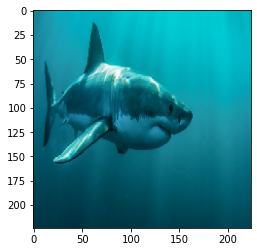

In [3]:
img = image.load_img('great_white_shark.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
plt.imshow(img)

## Predicting results

In [4]:
preds = model.predict(x)
print('Predictions :\n', decode_predictions(preds, top=3)[0])
class_index = np.argmax(preds[0])


Predictions :
 [('n01484850', 'great_white_shark', 0.982313), ('n01491361', 'tiger_shark', 0.005190771), ('n01494475', 'hammerhead', 0.0035491753)]


## Main Algorithm

In [5]:
# Getting images and layer ready
image_output = model.output[:, class_index] # last layer (prediction) neuron which contains the same class
last_conv_layer = model.get_layer('block5_conv3')

### Generating heatmap

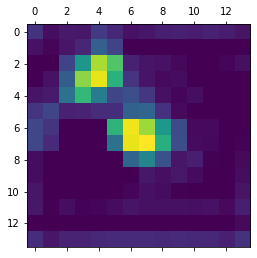

In [6]:
grads = K.gradients(image_output, last_conv_layer.output)[0] # Finding gradient of predicted class wrt feature maps of last conv layer
pooled_grads = K.mean(grads, axis=[0, 1, 2]) # Global average pooling to get neuron imp weights corresponding to the target class
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

# Finding "weight" of each feature map wrt prediction of target class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

# Applying ReLU in order to keep only the feature maps that have a positive impact on prediction

for x in range(heatmap.shape[0]):
    for y in range(heatmap.shape[1]):
        heatmap[x, y] = np.max(heatmap[x, y], 0)

# Normalising heatmap for visualising
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

### Superimposing heatmap on original image

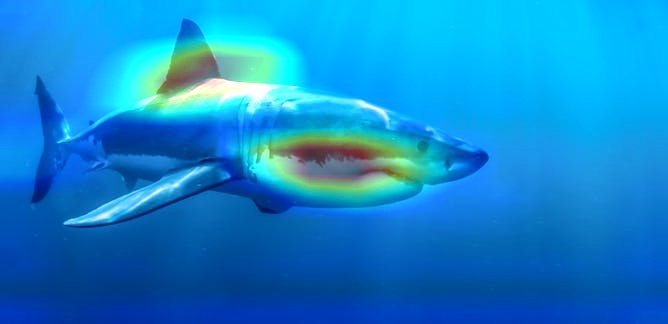

In [7]:
import cv2
img = cv2.imread('great_white_shark.jpg')
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap) # Convert to RGB
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.45 + img
cv2.imwrite('superimposed image.jpg', superimposed_img)

from IPython.display import Image
Image(filename='superimposed image.jpg')